Covariance Type: same_variance
Accuracy: 84.68%
Confusion Matrix:
[[693  47   7]
 [194 495  48]
 [ 26   5 619]]
Precision: [0.75903614 0.90493601 0.91839763], Mean Precision: 0.8607899284387671
Recall: [0.92771084 0.67164179 0.95230769], Mean Recall: 0.8505534422419875
F-Measure: [0.83493976 0.77102804 0.93504532], Mean F-Measure: 0.8470043712132886


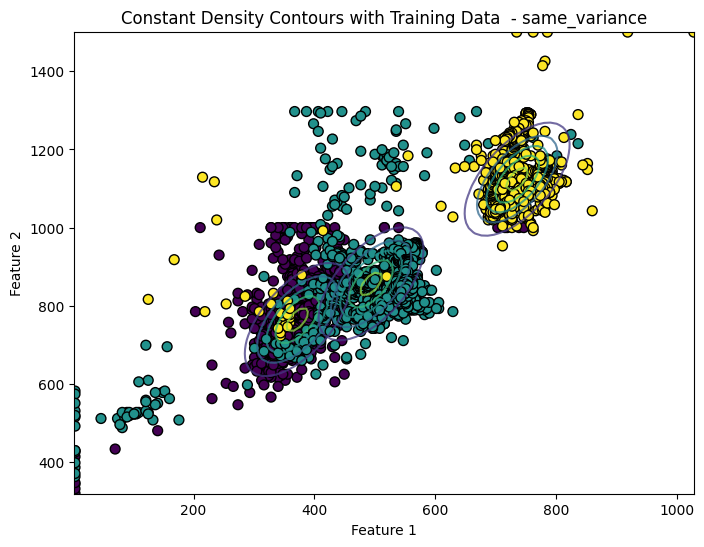

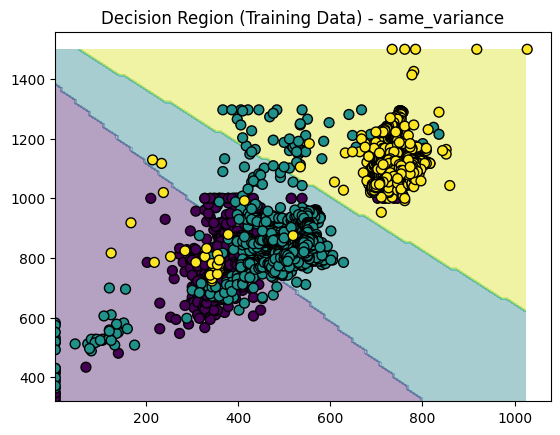

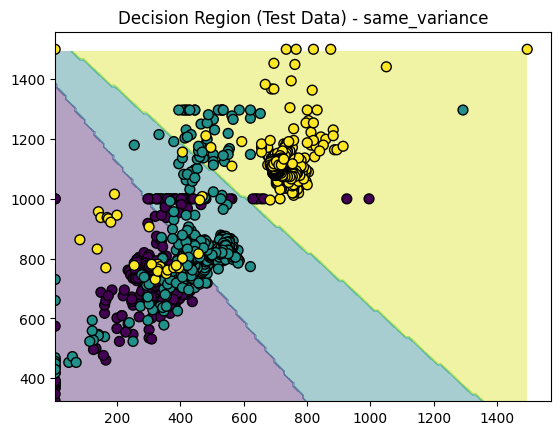

Covariance Type: same_full_cov
Accuracy: 86.41%
Confusion Matrix:
[[727  13   7]
 [217 500  20]
 [ 28   5 617]]
Precision: [0.74794239 0.96525097 0.95807453], Mean Precision: 0.8904226287479106
Recall: [0.97322624 0.67842605 0.94923077], Mean Recall: 0.8669610196925429
F-Measure: [0.84584061 0.79681275 0.95363215], Mean F-Measure: 0.8654285007946726


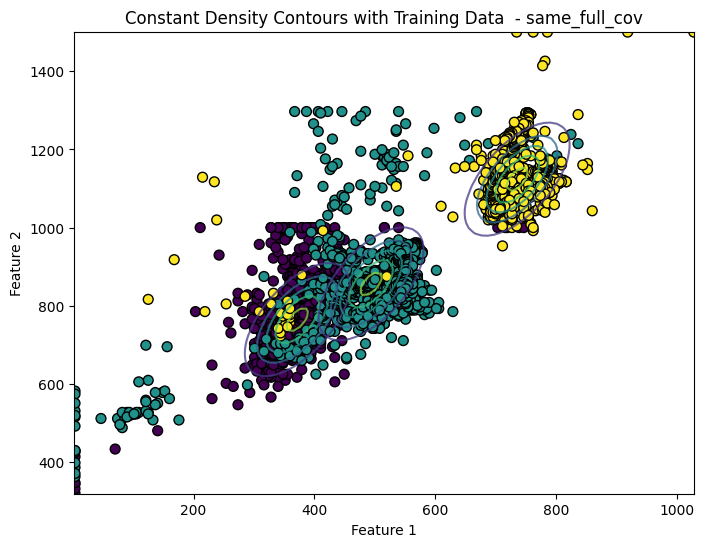

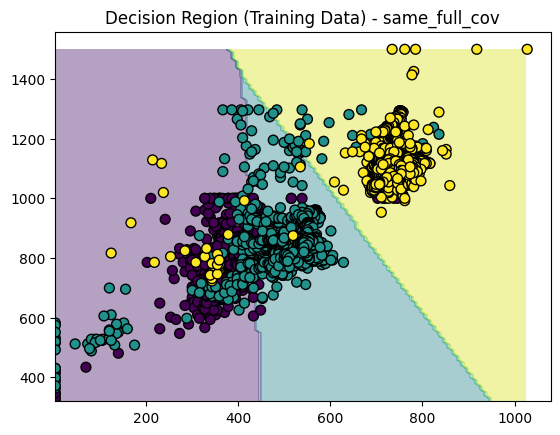

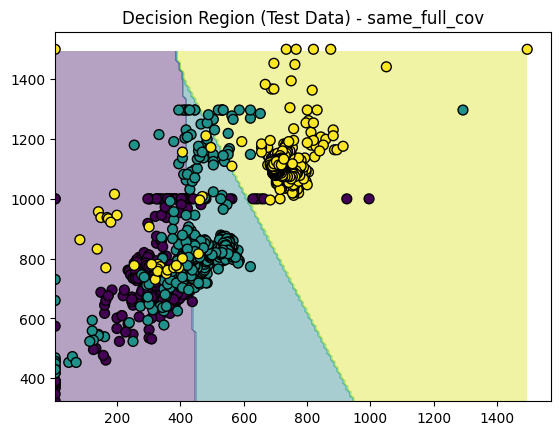

Covariance Type: different_diagonal
Accuracy: 84.54%
Confusion Matrix:
[[669  72   6]
 [200 518  19]
 [ 16  17 617]]
Precision: [0.7559322  0.85337727 0.96105919], Mean Precision: 0.856789552886621
Recall: [0.89558233 0.70284939 0.94923077], Mean Recall: 0.8492208293215308
F-Measure: [0.81985294 0.77083333 0.95510836], Mean F-Measure: 0.8485982112143103


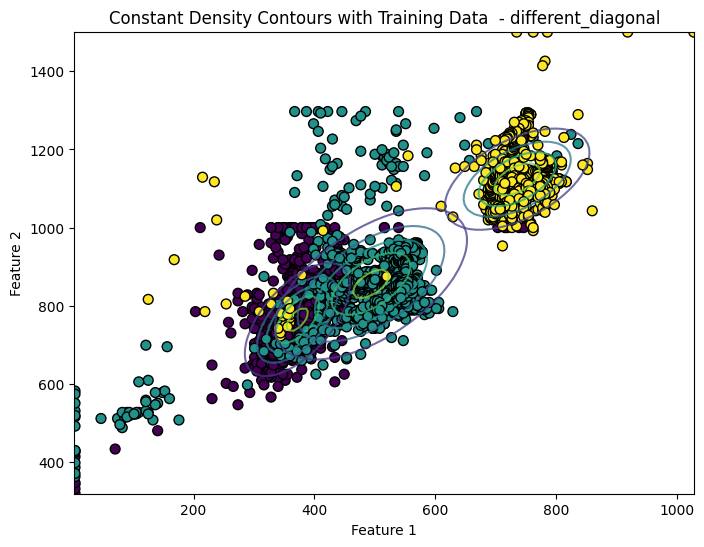

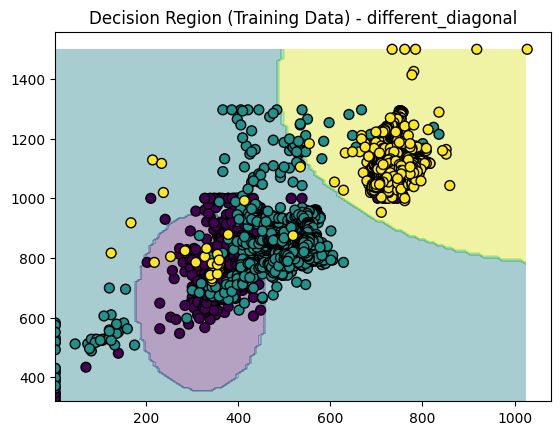

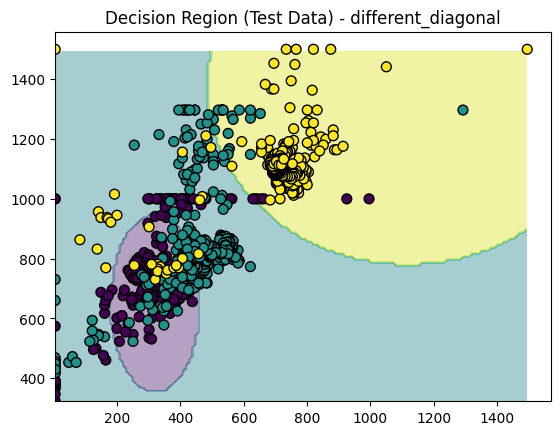

Covariance Type: different_full_cov
Accuracy: 83.41%
Confusion Matrix:
[[657  83   7]
 [225 507   5]
 [ 14  20 616]]
Precision: [0.73325893 0.83114754 0.98089172], Mean Precision: 0.8484327297667527
Recall: [0.87951807 0.68792402 0.94769231], Mean Recall: 0.8383781320878966
F-Measure: [0.79975654 0.75278396 0.96400626], Mean F-Measure: 0.8388489223518253


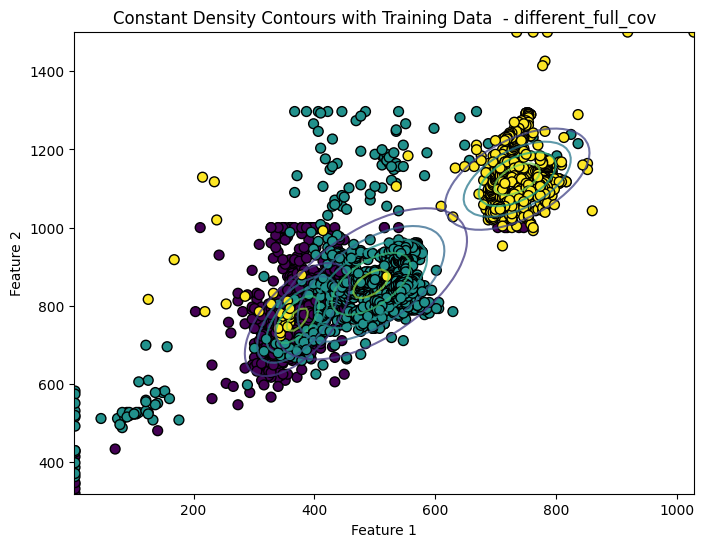

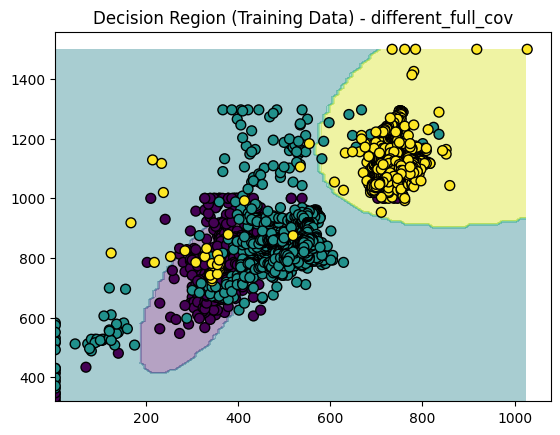

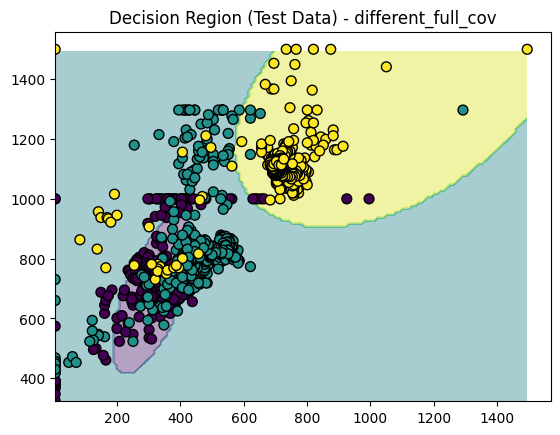

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset for vowel data from .txt files
def load_vowel_data(file_name):
    data = np.loadtxt(file_name)
    return data

# Combine all the class data into one dataset
def load_all_vowel_data(file_names):
    X, y = [], []
    for i, file_name in enumerate(file_names):
        class_data = load_vowel_data(file_name)
        labels = np.full(len(class_data), i + 1)  # Assign a class label (1, 2, 3,...)
        X.append(class_data)
        y.append(labels)
    return np.vstack(X), np.hstack(y)

# Split the dataset into training and testing (70-30 split)
def split_data(X, y, train_size=0.7):
    classes = np.unique(y)
    X_train, X_test, y_train, y_test = [], [], [], []

    for c in classes:
        X_class = X[y == c]
        y_class = y[y == c]
        split_index = int(train_size * len(X_class))

        X_train.append(X_class[:split_index])
        X_test.append(X_class[split_index:])
        y_train.append(y_class[:split_index])
        y_test.append(y_class[split_index:])

    return np.vstack(X_train), np.hstack(y_train), np.vstack(X_test), np.hstack(y_test)

# Custom function to calculate the mean (raw code)
def calculate_mean(X):
    # Mean for each feature across all samples
    mean = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        mean[i] = sum(X[:, i]) / X.shape[0]
    return mean

# Custom function to calculate covariance matrix (raw code)
def calculate_covariance(X):
    # Center the data by subtracting the mean of each feature
    mean = calculate_mean(X)
    X_centered = X - mean

    # Calculate the covariance matrix
    n_samples = X.shape[0]
    covariance = np.zeros((X.shape[1], X.shape[1]))
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            covariance[i, j] = sum(X_centered[:, i] * X_centered[:, j]) / (n_samples - 1)
    return covariance

# Custom function to calculate variance (raw code)
def calculate_variance(X):
    # Variance for each feature
    mean = calculate_mean(X)
    variance = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        variance[i] = sum((X[:, i] - mean[i]) ** 2) / (X.shape[0] - 1)
    return variance

# Multivariate Gaussian distribution
def multivariate_gaussian(x, mean, cov):
    d = len(mean)
    cov_inv = np.linalg.inv(cov)
    cov_det = np.linalg.det(cov)
    factor = 1.0 / np.sqrt((2 * np.pi) ** d * cov_det)
    exponent = -0.5 * np.dot(np.dot((x - mean).T, cov_inv), (x - mean))
    return factor * np.exp(exponent)

# Classifier with different covariance types
def bayes_classifier(X_train, y_train, X_test, covariance_type):
    classes = np.unique(y_train)
    means = []
    covariances = []

    # Calculate means and covariances for each class
    for c in classes:
        X_c = X_train[y_train == c]
        means.append(calculate_mean(X_c))
        covariances.append(calculate_covariance(X_c))

    # Handle different covariance types
    if covariance_type == 'same_variance':
        # Same Covariance Matrix (σ²) for All Classes
        variances = [np.diag(cov) for cov in covariances]
        avg_variance = sum(np.hstack(variances)) / len(np.hstack(variances))
        covariances = [avg_variance * np.eye(X_train.shape[1])] * len(classes)
    elif covariance_type == 'same_full_cov':
        # Full Covariance Matrix (Σ) Same for All Classes
        avg_cov = sum(covariances) / len(covariances)
        covariances = [avg_cov] * len(classes)
    elif covariance_type == 'different_diagonal':
        # Diagonal Covariance Matrix Different for Each Class
        covariances = [np.diag(np.diag(cov)) for cov in covariances]
    elif covariance_type == 'different_full_cov':
        # Full Covariance Matrix Different for Each Class
        pass  # Already calculated separately

    predictions = []
    for x in X_test:
        posteriors = []
        for idx, c in enumerate(classes):
            mean = means[idx]
            cov = covariances[idx]
            prior = sum(y_train == c) / len(y_train)
            likelihood = multivariate_gaussian(x, mean, cov)
            posterior = likelihood * prior
            posteriors.append(posterior)
        predictions.append(classes[np.argmax(posteriors)])

    return np.array(predictions)

# Custom function to plot the decision regions and contours
def plot_decision_regions(X, y, classifier, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 10), np.arange(y_min, y_max, 10))
    
    # Predict class labels for each point in the mesh
    Z = classifier(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary and data points
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=50)
    plt.title(title)
    plt.show()

# Confusion matrix and other metrics
def confusion_matrix_metrics(y_test, y_pred):
    classes = np.unique(y_test)
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype=int)

    for i, c_true in enumerate(classes):
        for j, c_pred in enumerate(classes):
            confusion_matrix[i, j] = sum((y_test == c_true) & (y_pred == c_pred))

    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f_measure = 2 * precision * recall / (precision + recall)

    mean_precision = np.nanmean(precision)
    mean_recall = np.nanmean(recall)
    mean_f_measure = np.nanmean(f_measure)

    return confusion_matrix, accuracy, precision, recall, f_measure, mean_precision, mean_recall, mean_f_measure
def plot_contour(X_train, y_train, means, covariances, title, covariance_type):
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    plt.figure(figsize=(8, 6))

    # Plot contours for each class based on the covariance type
    for mean, cov in zip(means, covariances):
        if covariance_type in ['same_variance', 'same_full_cov']:
            # Single shared covariance for all classes
            cov = covariances[0]  # Use the shared covariance matrix

        Z = np.array([multivariate_gaussian(np.array([x, y]), mean, cov) for x, y in zip(xx.ravel(), yy.ravel())])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=5, alpha=0.75)

    # Plot the training data points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Main function
if __name__ == '__main__':
    # Load vowel data files (e.g., vowel_class1.txt, vowel_class2.txt, vowel_class3.txt)
    file_names = ['class1.txt', 
                  'class2.txt', 
                  'class3.txt']
    X, y = load_all_vowel_data(file_names)

    # Split data into training and testing (70%-30%)
    X_train, y_train, X_test, y_test = split_data(X, y)

    # Different covariance types to test
    covariance_types = ['same_variance', 'same_full_cov', 'different_diagonal', 'different_full_cov']
    
    for cov_type in covariance_types:
        print(f"Covariance Type: {cov_type}")

        # Predictions
        predictions = bayes_classifier(X_train, y_train, X_test, covariance_type=cov_type)
        accuracy = sum(predictions == y_test) / len(y_test)
        print(f"Accuracy: {accuracy * 100:.2f}%")

        # Confusion matrix and metrics
        cm, acc, precision, recall, f_measure, mean_precision, mean_recall, mean_f_measure = confusion_matrix_metrics(y_test, predictions)
        print(f"Confusion Matrix:\n{cm}")
        print(f"Precision: {precision}, Mean Precision: {mean_precision}")
        print(f"Recall: {recall}, Mean Recall: {mean_recall}")
        print(f"F-Measure: {f_measure}, Mean F-Measure: {mean_f_measure}")

        # Plot decision regions
        classes = np.unique(y_train)
        means = [calculate_mean(X_train[y_train == c]) for c in classes]
        covariances = [calculate_covariance(X_train[y_train == c]) for c in classes]

        # Plot contour plots for training data with contours
        plot_contour(X_train, y_train, means, covariances, title=f"Constant Density Contours with Training Data  - {cov_type}", covariance_type=cov_type)
        plot_decision_regions(X_train, y_train, lambda x: bayes_classifier(X_train, y_train, x, covariance_type=cov_type), title=f"Decision Region (Training Data) - {cov_type}")
        plot_decision_regions(X_test, y_test, lambda x: bayes_classifier(X_train, y_train, x, covariance_type=cov_type), title=f"Decision Region (Test Data) - {cov_type}")
